In [8]:
!pip install pystan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h1>Cài đặt thư viện

Đầu tiên, ta thêm thư viện pandas, numpy và Prophet. 

In [10]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Thêm thư viện tắt thông báo

In [11]:
import warnings
warnings.simplefilter('ignore')

Thêm thư viện đọc dữ liệu của Google Drive

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

<h1>Đọc dữ liệu</h1>
Đầu vào của Prophet luôn là một tập dữ liệu với hai thuộc tính là ds và y. trong đó, ds có định dạng ngày, đánh dấu mốc thời gian. Và cột y đại diện cho giá trị định lượng, đại diện cho phép đo mà ta dự đoán.

In [14]:
train_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/8_2/eth/ethereum_train_8_2.csv", parse_dates=True, index_col=0)
train_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-06-01,0.23180,0.24981,0.23085,0.24797,11970598,USD
2020-06-02,0.24801,0.25321,0.22795,0.23794,12686011,USD
2020-06-03,0.23790,0.24476,0.23384,0.24452,8151002,USD
2020-06-04,0.24453,0.24641,0.23668,0.24337,8749785,USD
2020-06-05,0.24337,0.24750,0.23970,0.24023,7754761,USD


In [15]:
train = train_ETH[["Close"]]
train.head(5)

,Close
Date,
2020-06-01,0.24797
2020-06-02,0.23794
2020-06-03,0.24452
2020-06-04,0.24337
2020-06-05,0.24023


In [16]:
train = train.reset_index(level=0)
train.columns = ['ds','y']
train.head(5)

,ds,y
0,2020-06-01,0.24797
1,2020-06-02,0.23794
2,2020-06-03,0.24452
3,2020-06-04,0.24337
4,2020-06-05,0.24023


In [17]:
test_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/8_2/eth/ethereum_test_8_2.csv", parse_dates=True, index_col=0)
test_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2022-01-07,3.40722,3.41326,3.07730,3.19531,979252,USD
2022-01-08,3.19814,3.24446,3.00176,3.08002,566062,USD
2022-01-09,3.07989,3.21034,3.06047,3.15030,415868,USD
2022-01-10,3.15027,3.17996,2.93168,3.08543,804376,USD
2022-01-11,3.08464,3.26278,3.05340,3.23789,505208,USD


In [18]:
test = test_ETH[["Close"]]
test.head(5)

,Close
Date,
2022-01-07,3.19531
2022-01-08,3.08002
2022-01-09,3.15030
2022-01-10,3.08543
2022-01-11,3.23789


In [19]:
test = test.reset_index(level=0)
test.columns = ['ds','y']
test.tail(5)

,ds,y
141,2022-05-28,1.79268
142,2022-05-29,1.81356
143,2022-05-30,1.99846
144,2022-05-31,1.94179
145,2022-06-01,1.81807


In [20]:
df = pd.concat([train, test],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df.head(5)    

,ds,y
0,2020-06-01,0.24797
1,2020-06-02,0.23794
2,2020-06-03,0.24452
3,2020-06-04,0.24337
4,2020-06-05,0.24023


In [21]:
df.tail(5)    

,ds,y
726,2022-05-28,1.79268
727,2022-05-29,1.81356
728,2022-05-30,1.99846
729,2022-05-31,1.94179
730,2022-06-01,1.81807


<h1>Trực quan hóa dữ liệu

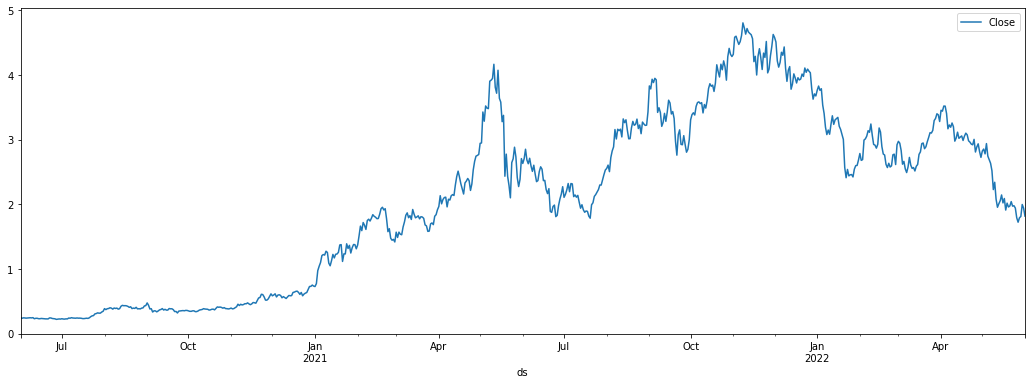

In [22]:
df.plot(x="ds", y='y',figsize=(18,6), label="Close")

<li>Ta xây dựng mô hình thông qua hàm Prophet()

In [23]:
interrupt = len(train)
interrupt

585

In [24]:
# Check size
print(train.shape)  
print(test.shape)  

(585, 2)
(146, 2)


In [25]:
future = df.copy()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


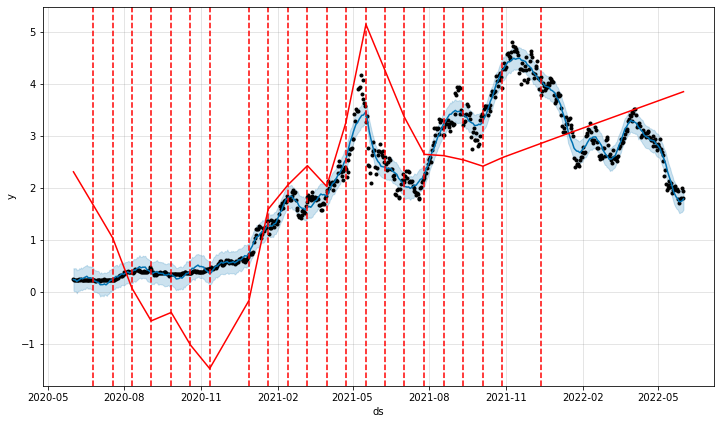

In [26]:
m = Prophet(changepoint_prior_scale=.99)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

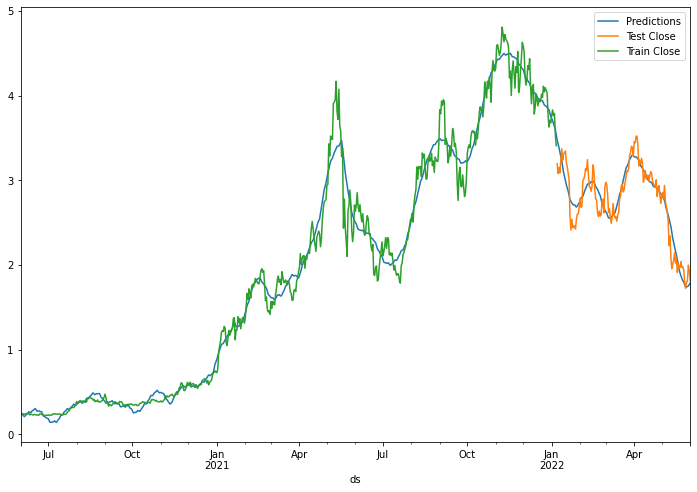

In [27]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
test.plot(x='ds',y='y',label='Test Close',legend=True,ax=ax)
train.plot(x='ds',y='y',label='Train Close',legend=True,ax=ax)
#,xlim=((datetime.strptime(current_time, '%Y-%m-%d') - timedelta(days = 30)).strftime("%Y-%m-%d"),current_time)

In [28]:
mae = mean_absolute_error(test.y, forecast[interrupt:].yhat)
mape = mean_absolute_percentage_error(test.y, forecast[interrupt:].yhat)
mse = mean_squared_error(test.y, forecast[interrupt:].yhat)
rmse = np.sqrt(mse)
r2 = r2_score(test.y, forecast[interrupt:].yhat)
# print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
# print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAPE: 4.83%
RMSE: 0.16
R2: 0.86
